# Fokker-Planck basics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

from sys import path
path.insert(0, "lib")
import Fokker_Planck as fp
from integrators import SGD

%load_ext autoreload
%autoreload 2

## Single-well potential
In this section, we compare Fokker-Planck and SGD dynamics in a single-well potential.
Specifically, we use a potential of the form $q(w) = w^a$. If $a>1$, the potential is singular. Otherwise, it is regular.

### Basics of the Fokker-Planck dynamics
`fipy` requires us that simulated interval is of the form $[0,L]$. We use the potential $q(w) = (w-L/2)^a$.

In [2]:
def simulate_sing(std_e, lr, b, dt, time, a, L, nw, w_left, w_right):
    """
    a: singularity coefficient
    """
    
    steps = int(time/dt)
    ve = std_e**2.
    v = 1
    
    w, w0 = sym.symbols('w w0')
    # potential
    q = (w-L/2)**a
    
    x, Ps = fp.run(q, nw, lr, v, ve, a, b, L, dt, steps, w_left, w_right)
    return q, x, Ps

Potential at time 0 and at some (relatively small) time

In [25]:
std_e = 1.
lr = .05
b = 20
time = 20
a = 2
L = 4.
w_left, w_right = -.5 + L/2, .5 + L/2
dt = .1
nw = 500

q, x, P = simulate_sing(ve, lr, b, dt, time, a, L, nw, w_left, w_right)

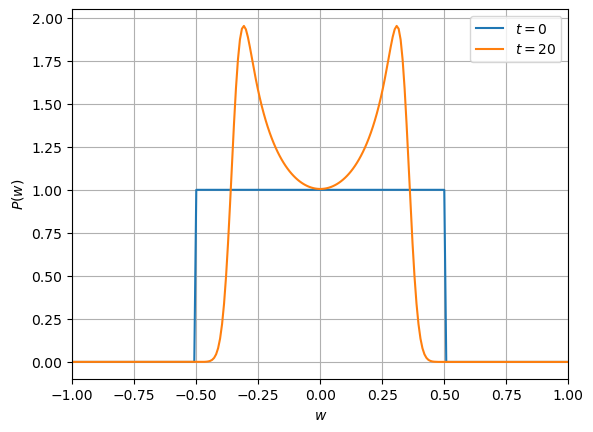

In [26]:
for it in [0, len(P)-1]:
    plt.plot(x-L/2, P[it], label=f'$t={it*dt:g}$')

plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.legend()
plt.xlim(-1,1)
plt.show()

Fixed-time comparisons with different singularity exponents

In [52]:
std_e = 1.
lr = .05
b = 20
time = 30
al = [1,2,3]
L = 4.
w_left, w_right = -.5 + L/2, .5 + L/2
dt = .1
nw = 500

xs, Ps = {}, {}
for a in al:
    q, xs[a], Ps[a] = simulate_sing(ve, lr, b, dt, time, a, L, nw, w_left, w_right)

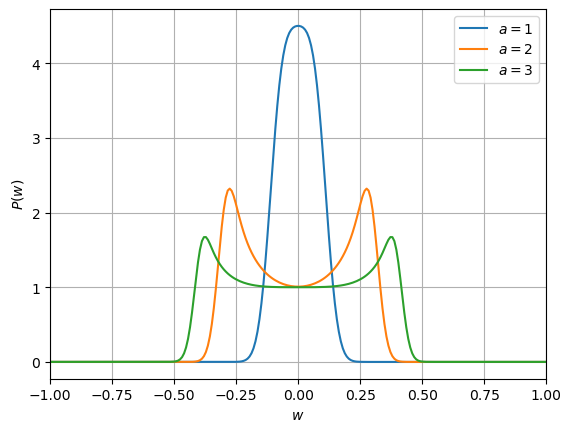

In [53]:
for a in al:
    plt.plot(xs[a]-L/2, Ps[a][-1], label=f'$a={a}$')

plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.legend()
plt.xlim(-1,1)
plt.show()

### Mean square distance
The mean square distance to the minimum is defined as follows:
$$
    \int P(w)(w-L/2)^2 dw
$$

First we check that $N_w = 100$ is a reasonably good spatial discretization:

In [30]:
std_e = 1.
ve = std_e**2.
lr = .05
b = 20
time = 100
al = 2
L = 4.
w_left, w_right = -.5 + L/2, .5 + L/2
dt = .1
nws = [50,100,500]

xs, Ps = {}, {}
for nw in nws:
    q, xs[nw], Ps[nw] = simulate_sing(ve, lr, b, dt, time, a, L, nw, w_left, w_right)

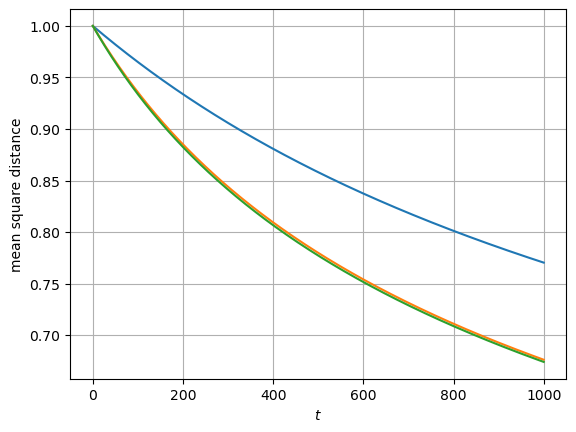

In [32]:

NT = int(time/dt) # number of time steps
for nw in nws:
    wx = [list(xs[nw]-L/2)]*(NT+1) # array of distances (from minimum)
    # mean square distance
    data = np.array(Ps[nw]) * np.array(wx)**2.
    # normalization
    data /= np.sum(data[0])
    msd = np.sum(data, axis=1)
    plt.plot(msd, label=f"$N_w={nw}$")
plt.xlabel("$t$")
plt.ylabel("mean square distance")
# plt.yscale('log')
# plt.xscale('log')
plt.grid()
plt.show()

Now we compare the dynamics for different singularity exponents

In [33]:
std_e = 1.
ve = std_e**2.
lr = .05
b = 20
time = 500
al = [1,2,3]
L = 4.
w_left, w_right = -.5 + L/2, .5 + L/2
dt = .1
nw = 100

xs, Ps = {}, {}
for a in al:
    q, xs[a], Ps[a] = simulate_sing(ve, lr, b, dt, time, a, L, nw, w_left, w_right)

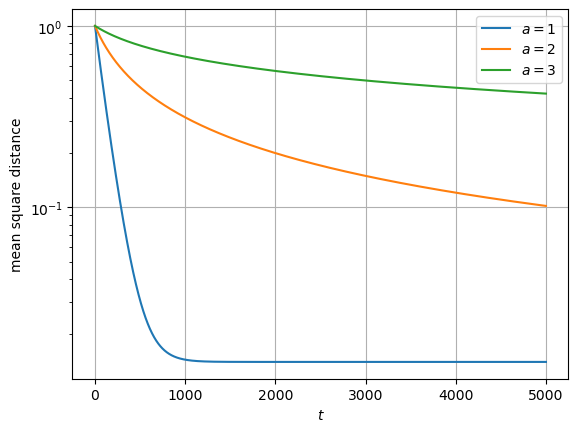

In [34]:

NT = int(time/dt) # number of time steps
for a in al:
    wx = [list(xs[a]-L/2)]*(NT+1) # array of distances (from minimum)
    # mean square distance
    data = np.array(Ps[a]) * np.array(wx)**2.
    # normalization
    data /= np.sum(data[0])
    msd = np.sum(data, axis=1)
    plt.plot(msd, label=f"$a={a}$")
plt.xlabel("$t$")
plt.ylabel("mean square distance")
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

### Comparison with SGD dynamics

In [35]:
def q(w):
    return w**a
    
def grad_q(w):
    return a*w**(a-1.)

def get_data_sing(seed):
    state = np.random.RandomState(seed=seed)
    w_init = state.uniform(-.5,.5)
    S = SGD(std_e, lr, q, grad_q, w_init, b, seed)
    S.evolve(time)
    return S.w

In [39]:
nsamp = 10**5
tmax = 20
sgd_data = np.array([get_data_sing(seed) for seed in range(nsamp, 2*nsamp)])

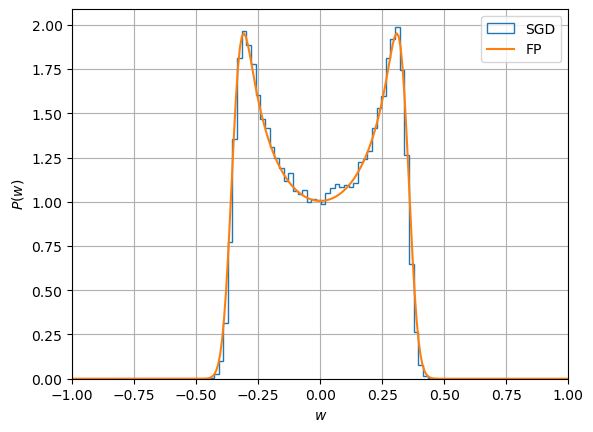

In [40]:
plt.hist(sgd_data.T[-1], histtype='step', density=True, bins='auto', label='SGD')
plt.plot(x-L/2, P[-1], label='FP')
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.legend()
plt.xlim(-1,1)
plt.savefig("dynamics_1d_singular_model.png", bbox_inches="tight", dpi=150)
plt.show()